# Area sampling using Dask and Xarray

In [2]:
from dask.distributed import Client
import xarray as xr
import numpy as np
import bottleneck
from datetime import datetime
import os
import rasterio as rio
import functools
import glob
import warnings
warnings.filterwarnings("ignore")

In [3]:
###### Define constants ###########
network_name = "California"
minx = -124.5
miny = 32.5
maxx = -114
maxy = 42.5
bbox = {'minx':minx, 'maxx':maxx, 'miny':miny, 'maxy':maxy}

# set the chunks
chunks = {'x': 100, 'y': 100}

startDate = datetime(2016, 1, 1)
endDate = datetime(2017, 1, 1)

SMAPL4_times = ['0130', '0430', '0730', '1030', '1330', '1630', '1930', '2230'] # 3-hourly data

###### PATH ###########
input_path = r"..\1_data"
output_path = r"..\3_data_out"
SMAPL3_path = "SPL3SMP_E"
SMAPL4_path = "SPL4SMGP"
SMAPL4_grid_path = "SMAPL4SMGP_EASEreference"
PET_path = "PET"

## Read data 

### Read SMAP L4 data

In [103]:
def _preprocess_SMAPL4(ds):
    # Assign missing time dimension
    startTime = datetime.strptime(ds.rangeBeginningDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    endTime = datetime.strptime(ds.rangeEndingDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    midTime = startTime + (startTime - endTime)/2
    ds = ds.assign_coords(time=midTime)
    return ds

# https://stackoverflow.com/questions/65376109/use-xarray-open-mfdataset-on-files-with-no-time-dimension-included

In [104]:
# Get a list of files 
# Test with 2016 Jan 1-9 data first
SMAPL4_fn_pattern = f'SMAP_L4_SM_gph_{startDate.year}010*.nc'
SMAPL4_file_paths = glob.glob(rf'{input_path}/{SMAPL4_path}/{SMAPL4_fn_pattern}')

# Load data
ds_SMAPL4 = xr.open_mfdataset(SMAPL4_file_paths, engine="rasterio", preprocess=_preprocess_SMAPL4, chunks=chunks, combine='nested', concat_dim='time')
# TODO/ISSUE #1: I need to use engine="rasterio" which takes x5 times than engine="netcdf4"
# Otherwise, precipitation variable is not read. 
# This is probably because precipitation variable is stored one level below of all other variables (lat, lon, etc.)
# 40sec to read 1 mo of data 
# TODO/ISSUE #2: Y axis is read upside down, so I need to reset the index 
# Debug attempt: 
# ds_SMAPL4 = ds_SMAPL4.reindex(y=ds_SMAPL4.y*(-1))
# But If I do this now, the chunking over the y axis disappers. 
# Debug attempt2: 
# ds_SMAPL4_P = ds_SMAPL4_P.isel(y=slice(None, -1))
# This just select the values and does not change the dimension values

# # https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset

In [137]:
ds_SMAPL4_P = ds_SMAPL4.precipitation_total_surface_flux.copy()
ds_SMAPL4_P

<xarray.DataArray 'precipitation_total_surface_flux' (time: 72, band: 1,
                                                      y: 1821, x: 3856)>
dask.array<getitem, shape=(72, 1, 1821, 3856), dtype=float32, chunksize=(1, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * band                    (band) int32 1
  * x                       (x) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * y                       (y) float64 -85.01 -84.92 -84.83 ... 84.81 84.9
  * time                    (time) datetime64[ns] 2015-12-31T22:30:00 ... 201...
    projection_information  int32 0
Attributes: (12/17)
    /Geophysical_Data/precipitation_total_surface_flux#coordinates:       /ce...
    /Geophysical_Data/precipitation_total_surface_flux#DIMENSION_LABELS:  {y,x}
    /Geophysical_Data/precipitation_total_surface_flux#fmissing_value:    -9999
    /Geophysical_Data/precipitation_total_surface_flux#grid_mapping:      pro...
    /Geophysical_Data/precipitation_total_surface_flux#long_name:         Tot...
    /Geophysical_Data/precipitation_total_surface_flux#missing_value:     -9999
    ...                                                                   ...
    DIMENSION_LABELS:                                                     {y,x}
    fmissing_value:                                                       -9999
    long_name:                                                            Tot...
    units:                                                                kg ...
    valid_max:                                                            0.0...
    valid_min:                                                            0

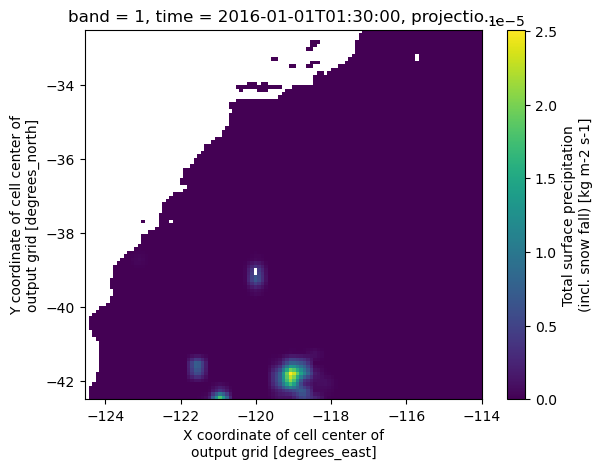

In [140]:
ds_SMAPL4_P_clipped = ds_SMAPL4_P.sel(x=slice(minx, maxx), y=slice(maxy*(-1), miny*(-1)))
ds_SMAPL4_P_clipped.sel(time='2016-01-01 01:30:00').plot()
# ds_SMAPL4_P.rio.write_crs('epsg:4326', inplace=True)

### Read SMAP L3 data

In [19]:
def _preprocess_SMAPL3(ds):
    # Assign missing time dimension
    # Doesn't care about time as it is daily data
    startTime = datetime.strptime(ds.rangeBeginningDateTime.split("T")[0], '%Y-%m-%d')
    ds = ds.assign_coords(time=startTime)
    return ds

In [21]:
# Get a list of files 
# Test with 2016 Jan 1-9 data first
SMAPL3_fn_pattern = f'SMAP_L3_SM_P_E_{startDate.year}010*.nc'
SMAPL3_file_paths = glob.glob(rf'{input_path}/{SMAPL3_path}/{SMAPL3_fn_pattern}')
# Load data
ds_SMAPL3 = xr.open_mfdataset(SMAPL3_file_paths, preprocess=_preprocess_SMAPL3, engine="rasterio", chunks=chunks, combine="nested", concat_dim="time")
ds_SMAPL3
# 3.3 sec for 1 mo of data

<xarray.Dataset>
Dimensions:                 (band: 1, x: 3856, y: 1822, time: 9)
Coordinates:
  * band                    (band) int32 1
  * x                       (x) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * y                       (y) float64 85.0 84.9 84.81 ... -84.83 -84.92 -85.01
    /crs                    int32 0
  * time                    (time) datetime64[ns] 2016-01-01 ... 2016-01-09
Data variables:
    EASE_column_index       (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    longitude_pm            (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    retrieval_qual_flag_pm  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    soil_moisture_pm        (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    EASE_row_index          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    latitude                (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    longitude               (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    retrieval_qual_flag     (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    soil_moisture           (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    EASE_column_index_pm    (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    EASE_row_index_pm       (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    latitude_pm             (time, band, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
Attributes: (12/82)
    antennaRotationRate:                  14.6
    description:                          A configuration file generated auto...
    identifier:                           L3_SM_P_E_SPS
    edition:                              1.0
    publicationDate:                      2013-02-08
    title:                                Product Specification Document for ...
    ...                                   ...
    identifier_product_DOI:               doi:10.5067/4DQ54OUIJ9DL
    longName:                             SMAP Enhanced L3 Radiometer Global ...
    mission:                              SMAP
    pointOfContact:                       National Snow and Ice Data Center
    resourceProviderOrganizationName:     National Aeronautics and Space Admi...
    revisionDate:                         2021-08-31

### Read Singer PET data

In [25]:
# Get a list of files 
# Test with 2016 Jan 1-9 data first
PET_fn_pattern = f'*_daily_pet.nc'
PET_file_paths = glob.glob(rf'{input_path}/{PET_path}/{PET_fn_pattern}')
PET_file_paths
# Load data
ds_PET = xr.open_mfdataset(PET_file_paths, combine="nested", concat_dim="time")
ds_PET

<xarray.Dataset>
Dimensions:    (time: 2557, latitude: 1801, longitude: 3600)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Data variables:
    pet        (time, latitude, longitude) float32 dask.array<chunksize=(365, 1801, 3600), meta=np.ndarray>